<a href="https://colab.research.google.com/github/johnnysDeu/Thesis/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=jztwpsIzEGc

Building a CNN from scratch with any image dataset

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
#!nvidia-smi

In [6]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
# add headings with ##(space) on the markdowns

In [8]:
#!pip install tensorflor keras

In [9]:
import tensorflow as tf
import os

In [10]:
!nvidia-smi

Wed May 29 20:35:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   46C    P8              16W / 125W |    805MiB /  6144MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
#! nvidia-smi

In [14]:
#!pip install opencv-python

## Imports

In [15]:
import tensorflow as tf
import os
import cv2
import imghdr

In [16]:
#from google.colab import drive
#drive.mount('/content/drive')

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [19]:
#path = '/content/drive/MyDrive/Colab Notebooks/Thesis/data'
#os.chdir(path)

In [20]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [21]:
#data_dir='data_medium'
data_dir='READY_BALANCED_SAME_SIZE'
os.listdir(data_dir)

['Ads', 'Sample_Images']

In [22]:
#os.listdir(os.path.join(data_dir,'Ads'))

In [23]:
imgTest= cv2.imread(os.path.join('data','Ads','converted_iframe_9_AD.jpg'))

In [24]:
type(imgTest)

NoneType

In [25]:
#imgTest.shape

In [26]:
#plt.imshow(imgTest)

In [27]:
#plt.imshow(cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB))
#plt.show()

# Load Data

In [28]:
#tf.data.Dataset??

In [29]:
#tf.keras.utils.audio_dataset_from_directory??

In [30]:
data=tf.keras.utils.image_dataset_from_directory('READY_BALANCED_SAME_SIZE', batch_size=32, image_size=(224,224))
#data=tf.keras.utils.image_dataset_from_directory('data_medium', batch_size=32, image_size=(150,150))

Found 35776 files belonging to 2 classes.


In [31]:
data_iterator=data.as_numpy_iterator()


In [32]:
batch=data_iterator.next()


In [33]:
len(batch) # batch contain 2 items, the image batch[0] and the label batch[1]

2

In [34]:
batch[0].shape # images are numpy arrays

(32, 224, 224, 3)

In [35]:
batch[1] # labels

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1])

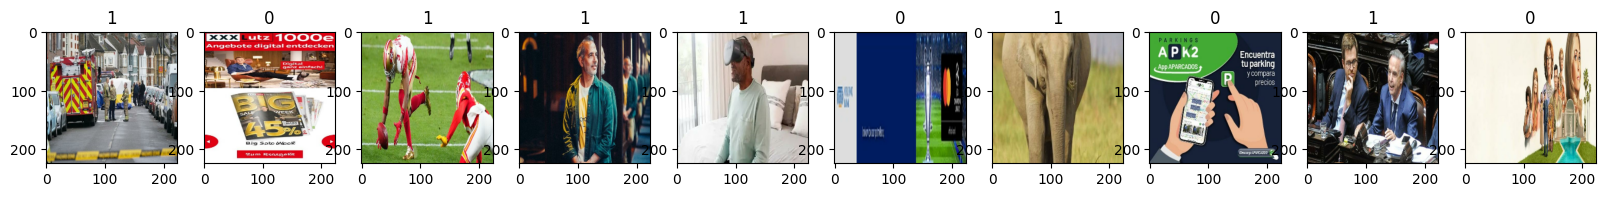

In [36]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20)) # class 1= simple image, class 0 = Ad
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

From the above plot, we see how the function assigns the classes (this may change from run-to-run):

simple image = 1 <br>
Ad = 0

## Preprocess data

In [37]:
print(batch[0].max()) # our pixels are between values 0 and 255. we will scale them to be between 0 and 1

255.0


In [38]:
#batch[0] / 255

In [39]:
scaled= data.map(lambda x,y: (x/255, y)) # as we load a batch from the pipeline, we scale them on the go

In [40]:
#scaled.as_numpy_iterator().next()

In [41]:
scaled_iterator=scaled.as_numpy_iterator()

In [42]:
batch = scaled_iterator.next()

In [43]:
batch[0].max()

1.0

In [44]:
#scaled.as_numpy_iterator().next()

# Split Data

In [45]:
#len(scaled)
len(data)

1118

In [46]:
train_size = int(len(scaled)*.7)# batch size 32
val_size = int(len(scaled)*.2) #
test_size = int(len(scaled)*.1) #

In [47]:
print(f'Train Size: {train_size}, Val Size:{val_size}, Test Size: {test_size}')


Train Size: 782, Val Size:223, Test Size: 111


In [48]:
train = scaled.take(train_size)
val = scaled.skip(train_size).take(val_size)
test = scaled.skip(train_size+val_size).take(test_size)

In [49]:
#train.as_numpy_iterator().next()[0]

In [50]:
#batch[0]

In [51]:
len(train)

782

# Model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten ,Dropout, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam, Adagrad

In [53]:
SEED = 42 # to always get same dropout and shuffle

In [54]:
def allcnn(weights=None):
    model = Sequential()
    model.add(Conv2D(32, (3,3), 1, padding = 'same', activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))

    model.add(Conv2D(64, (3,3), 1, padding = 'same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))

    model.add(Conv2D(128, (3,3), 1, padding = 'same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))

    model.add(Conv2D(128, (3,3), 1, padding = 'same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5, seed=SEED))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))
    model.add(Dense(1, activation='sigmoid'))

        # load the weights
    if weights:
        model.load_weights(weights)

    # return model
    return model

In [55]:
# build model
model = allcnn()

In [56]:
# define hyper parameters
learning_rateSGD = 0.01
LEARNING_RATE = 0.001
weight_decay = 1e-6
momentum = 0.9
beta1 = 0.9
beta2 = 0.999
epsilon=1e-07
RHO = 0.9

In [57]:
# sgd = SGD(learning_rate=learning_rateSGD, momentum=momentum, nesterov=True)

# rmsprop = RMSprop(learning_rate=LEARNING_RATE, rho=RHO, momentum=momentum, epsilon=epsilon, centered=False)

# adam = Adam(learning_rate=LEARNING_RATE, beta_1=beta1, beta_2=beta2, epsilon=epsilon)


In [58]:
model.compile(optimizer = 'Adagrad', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                        

# Train

In [60]:
hist = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
782/782 [==============================] - 64s 75ms/step - loss: 0.4678 - accuracy: 0.7948 - val_loss: 0.3535 - val_accuracy: 0.8552
Epoch 2/30
782/782 [==============================] - 58s 75ms/step - loss: 0.3603 - accuracy: 0.8495 - val_loss: 0.3315 - val_accuracy: 0.8636
Epoch 3/30
782/782 [==============================] - 60s 76ms/step - loss: 0.3293 - accuracy: 0.8614 - val_loss: 0.3096 - val_accuracy: 0.8753
Epoch 4/30
782/782 [==============================] - 58s 75ms/step - loss: 0.2998 - accuracy: 0.8772 - val_loss: 0.3024 - val_accuracy: 0.8799
Epoch 5/30
782/782 [==============================] - 58s 74ms/step - loss: 0.2789 - accuracy: 0.8878 - val_loss: 0.2908 - val_accuracy: 0.8814
Epoch 6/30
782/782 [==============================] - 58s 74ms/step - loss: 0.2603 - accuracy: 0.8944 - val_loss: 0.2900 - val_accuracy: 0.8845
Epoch 7/30
782/782 [==============================] - 58s 74ms/step - loss: 0.2475 - accuracy: 0.8994 - val_loss: 0.2980 - val_accuracy:

In [61]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [62]:
model.save(os.path.join('models','ad_classifier_clean_medium35000_Model.keras'))

In [63]:
val_acc_per_epoch = hist.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 28


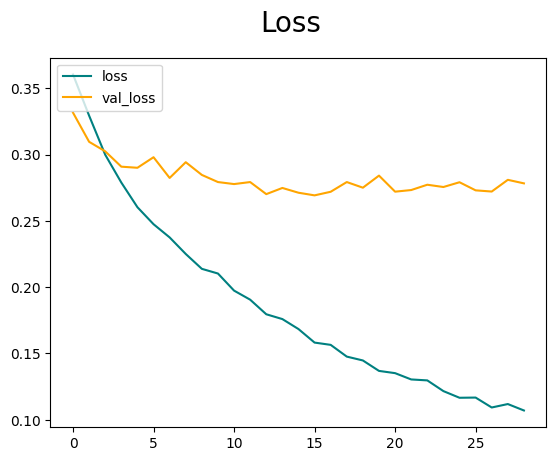

In [64]:
fig = plt.figure()
plt.plot(hist.history['loss'][1:], color='teal', label='loss')
plt.plot(hist.history['val_loss'][1:], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

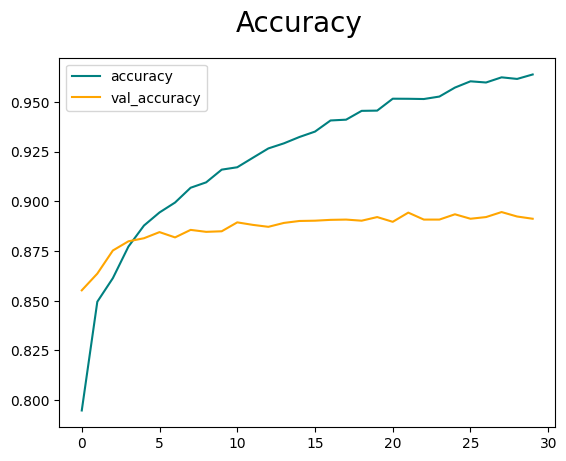

In [65]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [66]:

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [67]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
av_pre = []

In [112]:
# 
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    print(y)


1/1 [==============================] - 0s 62ms/step
[0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0]
1/1 [==============================] - 0s 28ms/step
[0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1]
1/1 [==============================] - 0s 28ms/step
[1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1]
1/1 [==============================] - 0s 26ms/step
[1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0]
1/1 [==============================] - 0s 26ms/step
[0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1]
1/1 [==============================] - 0s 27ms/step
[0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0]
1/1 [==============================] - 0s 27ms/step
[1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0]
1/1 [==============================] - 0s 28ms/step
[1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0]
1/1 [==============================] - 0s 31ms/step
[0 0

In [113]:
print(f'Precision: {pre.result()}, Recall:{re.result()}, Accuracy: {acc.result()}')

Precision: 0.8782135248184204, Recall:0.9027777910232544, Accuracy: 0.8917980194091797


Confution Matrix

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [122]:
print(test_size) 

111


In [123]:
for batch in test.as_numpy_iterator():  # batch = 32
    X, y = batch

    yhat = model.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)


    

1/1 [==============================] - 0s 25ms/step


In [124]:
print(true_labels)
print(predicted_labels)

    #print(y)

[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 

In [125]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [126]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

Ads = 0 

Clear = 1

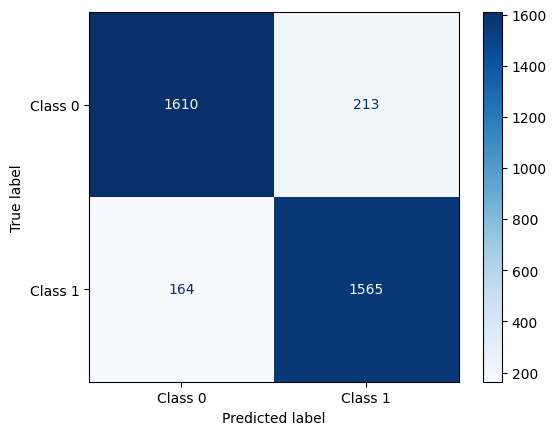

In [127]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Extra Testing on Unseen Data

In [69]:
import cv2

In [70]:
Current_dir = os.getcwd()
Current_dir
#os.chdir('..')
#os.chdir('Thesis')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [71]:
#img = cv2.imread('sim.jpg')
#img= cv2.imread(os.path.join('testData','4.png')) # s (246).jpg, 9.png, 4.png, s (481).jpg
img= cv2.imread(os.path.join('unseen data','main_12.jpg')) #
#img

In [72]:
len(img)


384

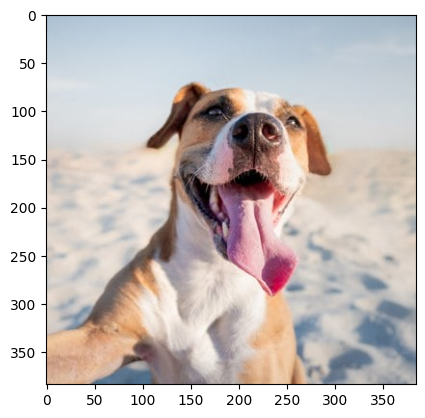

In [73]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [74]:
resize = tf.image.resize(img, (224,224))
#plt.imshow(resize.numpy().astype(int))
#plt.show()

In [75]:
resize.shape

TensorShape([224, 224, 3])

In [76]:
np.expand_dims(resize,0).shape

(1, 224, 224, 3)

In [77]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 384ms/step


array([[0.8572797]], dtype=float32)

simple image = 1 <br>
Ad = 0

In [78]:
#class 1= simple img, class 0 = Ad

if yhat > 0.5:
    print(f'Predicted Simple Image')
else:
    print(f'Predicted Ad')

Predicted Simple Image


# Loading the model

In [79]:
from keras.models import load_model
import keras

In [80]:
loaded_model = keras.saving.load_model(os.path.join('models',"ad_classifier_first_small_Model.keras"))
loaded_model.summary()

AttributeError: module 'keras.saving' has no attribute 'load_model'

Check also the following article https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

Keras Tuner : https://www.tensorflow.org/tutorials/keras/keras_tuner

Example model : https://www.tensorflow.org/tutorials/images/classification

